In [1]:
import os, sys, shutil
import pathlib
import glob as glob
import numpy as np
import re
import warnings
import mdtraj as md
import pandas as pd
#import dataframe_image as dfi
from itertools import combinations, combinations_with_replacement, product

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.neighbors import NearestCentroid
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

import barnaba as bb
import barnaba.cluster as cc

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
import seaborn as sns
from IPython.display import display

In [2]:
pd.options.display.max_rows = None
pd.options.display.max_columns = None
pd.options.display.precision = 1
pd.options.display.float_format = '{:.1f}'.format

In [3]:
plt.rcParamsDefault

RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'axes.grid': False,
          'axes.grid.axis': 'both',
          'axes.grid.which':

In [4]:
params = {'legend.fontsize': 40, 
          'font.size': 40, 
          'axes.labelsize': 48,
          'axes.titlesize': 48,
          'xtick.labelsize': 40,
          'ytick.labelsize': 40,
          'savefig.dpi': 600, 
          'figure.figsize': [64, 8],
          'xtick.major.size': 10,
          'xtick.minor.size': 7,
          'ytick.major.size': 10,
          'ytick.minor.size': 7}

plt.rcParams.update(params)

In [5]:
sys.stderr = sys.__stderr__

# Loading /Users/takabak/work/rna_bgsu/pdb/motif//HairpinLoopMotifAtlasRelease3.57/triplebase/HL_05123.1_GGG_4.pdb 
# Loading /Users/takabak/work/rna_bgsu/pdb/motif//HairpinLoopMotifAtlasRelease3.57/triplebase/HL_05123.1_GGG_4.pdb 
# Loading /Users/takabak/work/rna_bgsu/pdb/motif//HairpinLoopMotifAtlasRelease3.57/triplebase/HL_05123.1_GGG_4.pdb 
# Loading /Users/takabak/work/rna_bgsu/pdb/motif//nrlist_3.233_2.5A/JunctionLoop/triplebase/J3_7RQB_036_GGG_3.pdb 
# Loading /Users/takabak/work/rna_bgsu/pdb/motif//nrlist_3.233_2.5A/JunctionLoop/triplebase/J3_7RQB_036_GGG_3.pdb 
# Loading /Users/takabak/work/rna_bgsu/pdb/motif//nrlist_3.233_2.5A/JunctionLoop/triplebase/J3_7RQB_036_GGG_3.pdb 
# Loading /Users/takabak/work/rna_bgsu/pdb/motif//HairpinLoopMotifAtlasRelease3.57/triplebase/HL_18785.1_GGG_4.pdb 
# Loading /Users/takabak/work/rna_bgsu/pdb/motif//HairpinLoopMotifAtlasRelease3.57/triplebase/HL_18785.1_GGG_4.pdb 
# Loading /Users/takabak/work/rna_bgsu/pdb/motif//HairpinLoopMotifAtlasRele

In [6]:
def load_file(files, dump_path):
    """
    Load pdb files as trajectory 
    
    Parameters
    ----------
    files :
        PDB files in full path
    dump_path :
        Full path pointing to the dump directory to store deleted PDB files from the trajectory list

    Returns
    -------
    trajs : list of obj
        List of trajectory object loaded by MDTraj
    """ 
    # load files and get maximum number of atoms and residues within the file
    trajs = [ md.load_pdb(f) for f in files ]    
    n_atoms = [ traj.topology.n_atoms for traj in trajs ]
    n_residues = [ traj.topology.n_residues for traj in trajs ]
    max_atoms = max(n_atoms)
    max_residues = max(n_residues)
    #print(n_atoms.index(max_atoms), files[n_atoms.index(max_atoms)])

        
    # check atom numbers
    indexes = []
    for i, traj in enumerate(trajs):
        if max_atoms != traj.topology.n_atoms or max_residues != traj.topology.n_residues:
            print("{} removed from list".format(os.path.basename(files[i])))
            if max_atoms != traj.topology.n_atoms:
                print("Missing atoms? Expected number of atoms: {} / Actual number of atoms: {}".format(max_atoms, traj.topology.n_atoms))
            if max_residues != traj.topology.n_residues:
                print("Duplicate residue numbers? Expected number of residues: {} / Actual number of residues: {}".format(max_residues, traj.topology.n_residues))
            shutil.copy(files[i], dump_path)
            indexes.append(i)
            

    # delete files
    if indexes != []:
        for index in sorted(indexes, reverse=True):
            #print("delete index #{}".format(index))
            #del trajs[index]
            del files[index]  
 
    return files

In [7]:
def psuedo_angles(file):
    traj = md.load_pdb(file)
    residues = [ residue for residue in traj.topology.residues ]

    r_minus = residues[0] 
    r = residues[1]
    r_plus = residues[2]

    idx_theta = [ r_minus.atom("C4'").index, r.atom("P").index, r.atom("C4'").index, r_plus.atom("P").index ]
    idx_eta = [ r.atom("P").index, r.atom("C4'").index, r_plus.atom("P").index, r_plus.atom("C4'").index ]

    p1 = float(md.compute_dihedrals(traj, np.array(idx_theta).reshape(1,4)))
    p2 = float(md.compute_dihedrals(traj, np.array(idx_eta).reshape(1,4)))

    angles_psuedo = np.array([p1, p2])
    
    return angles_psuedo

In [8]:
def dist_featurizer(curated_files, atom_slice_interval):
    """
    Calculate internal atom distances
    """

    trajs = [ md.load_pdb(f) for f in curated_files ]    
    
    # case 1)
    #atom_indices = [ a.index for a in trajs[0].topology.atoms ]
    #atom_pairs = list(combinations(atom_indices[::atom_slice_interval], 2))
    
    # case 2)
    #atom_indices = [ a.index for a in trajs[0].topology.atoms if a.element.symbol is not 'C' ]
    #atom_pairs = list(combinations(atom_indices[::atom_slice_interval], 2))

    # case 3)
    atom_indices = [ a.index for a in trajs[0].topology.atoms if (a.name == "P" or a.name == "O2'" or a.name == "O3'" or a.name == "O4'" or a.name == "N2" or a.name == "N4" or a.name == "N6" or a.name == "O2" or a.name == "O4" or a.name == "O6") ] 
    atom_pairs = list(combinations(atom_indices, 2))
    
    #for _ in atom_indices[::atom_slice_interval]:
    #    print("{}".format(trajs[0].topology.atom(_)))
    
    feat = [ md.compute_distances(traj, atom_pairs, periodic=False, opt=True)[0] for traj in trajs ]
    feat = np.array(feat)
    
    return feat

In [9]:
def torsion_featurizer(curated_files):
    """
    Calculate 6 torsion angles (α, β, γ, δ, ε, and ζ) around the consecutive chemical bonds, chi (χ) quantifying the relative base/sugar orientation, plus the sugar pucker.
    https://x3dna.org/highlights/pseudo-torsions-to-simplify-the-representation-of-dna-rna-backbone-conformation
    
    """    
    # step1) calculate torsions
    arr = []
    for file in curated_files:        
        angles_bb, res = bb.backbone_angles(file)  # backbone torsion and sugar/base torsion
        angles_s, res = bb.sugar_angles(file)      # sugar torsion
        angles_p, res = bb.pucker_angles(file)     # pucker angle
        angles_psuedo = psuedo_angles(file)        # psuedo angle

        # concatenate backbone, sugar, and pucker torsions
        _angles = np.concatenate((angles_bb[0], angles_s[0]), axis=1)
        angles = np.concatenate((_angles, angles_p[0]), axis=1)  

        # concatenate psuedo torsions
        angles = angles.flatten()
        angles = np.concatenate((angles, angles_psuedo))        
        arr.append(angles)


    # step2) find array index with nan
    a = []
    arr = np.array(arr)    
    for x in arr:
        a.append(np.argwhere(np.isnan(x)))
    a = np.array(a)
    a = a.flatten()
    nan_indexes = set(a)
    
    # step3) remove nan from torsion array
    feat = []
    for a in arr:
        for i in sorted(nan_indexes, reverse=True):
            #print(i)
            a = np.delete(a, i)
        feat.append(a)
    feat = np.array(feat)
    feat = np.rad2deg(feat)
    
    return feat

In [10]:
def dbscan_cluster(feat, params):
    """
    """
    cluster = DBSCAN(eps=params["eps"], min_samples=2).fit(feat)    
    print(cluster.labels_)

    clf = NearestCentroid()
    clf.fit(feat, cluster.labels_)
    centroid_feat = clf.centroids_
    #centroid_indexes = find_cluster_centroid(centroid_feat, feat, cluster.labels_)
    centroid_indexes = find_cluster_centroid_within_cluster(centroid_feat, feat, cluster.labels_)
    
    return cluster.labels_, centroid_indexes

In [11]:
def agglomerative_cluster(feat, params):
    """
    Agglomerative clustering (bottom-up hierarchical clustering)
    
    Parameters
    ----------
    feat : numpy array of float
        Numpy array of features
    params : dictionary
        Clustering parameters

    Returns
    -------
    cluster.labels_ : list of int
        List of cluster id
    centroid_indexes : list of int
        List index pointing to the nearest centroid coordinates
    """
        
    # https://aiaspirant.com/hierarchical-clustering/
    cluster = AgglomerativeClustering(n_clusters=None, distance_threshold=params["threshold"], compute_distances=True, linkage=params["method"], affinity="euclidean").fit(feat)    
    if len(set(cluster.labels_)) == 1:
        print("Only one cluster defined. Set n_clusters to 2")
        cluster = AgglomerativeClustering(n_clusters=2, compute_distances=True, linkage=params["method"], affinity="euclidean").fit(feat)    

    clf = NearestCentroid()
    clf.fit(feat, cluster.labels_)
    centroid_feat = clf.centroids_
    #centroid_indexes = find_cluster_centroid(centroid_feat, feat, cluster.labels_)
    centroid_indexes = find_cluster_centroid_within_cluster(centroid_feat, feat, cluster.labels_)
    
    return cluster.labels_, centroid_indexes

In [12]:
def find_cluster_centroid_within_cluster(centroid_feat, feat, cluster_labels):
    """
    Find cluster centroid
    
    Parameters
    ----------
    centroid_feat : array
        Array of centroid features
    feat : array
        Array of internal distances obtained from list of trajectories
    cluster_labels : list of int
        List of cluster id

    Returns
    -------
    centroid_indexes : list of int
        List index pointing to the nearest centroid coordinates within each cluster
    """    
    centroid_indexes = []
    
    for cluster_id in range(len(centroid_feat)):
        indexes = np.where(cluster_labels == cluster_id)[0]
        _feat = [ feat[index] for index in indexes ]
        
        arr = []
        for d in _feat:
            v = 0
            delta = d - centroid_feat[cluster_id]
            for x in delta:
                v += np.square(x)
            arr.append(np.sqrt(v))

        arr = np.array(arr)
        i = np.where(arr==arr.min())  

        # e.g. i --> (array([323, 378]),)                    
        if len(i[0]) != 1:  
            ncls = len(indexes)
            if ncls != 2:
                print("cluster #{}: Found {} samples but more than one index was assigned as centroid ({})".format(i, ncls, cluster_id))
                print("array: {}".format(arr))
                print("centroid_feature: {}".format(centroid_feat[cluster_id]))
                print("feature1: {}".format(feat[i[0][0]]))
                print("feature2: {}".format(feat[i[0][1]]))
            i = int(i[0][0])
        else:
            i = int(i[0])
        
        index = indexes[i]
        centroid_indexes.append(index)

       
    return centroid_indexes

In [13]:
def find_cluster_centroid(centroid_feat, feat, cluster_labels):
    """
    Find cluster centroid
    
    Parameters
    ----------
    centroid_feat : array
        Array of centroid features
    feat : array
        Array of internal distances obtained from list of trajectories
    cluster_labels : list of int
        List of cluster id

    Returns
    -------
    centroid_indexes : list of int
        List index pointing to the nearest centroid coordinate
    """    
    centroid_indexes = []
    
    for cid in range(len(centroid_feat)):
        arr = []
        for i in range(len(feat)):
            v = 0
            delta = feat[i] - centroid_feat[cid]
            for x in delta:
                v += np.square(x)
            #arr.append(np.sqrt(v))
            arr.append(v)

        arr = np.array(arr)
        i = np.where(arr==arr.min())  

        # More than one index could be assigned as centroids if the number of samples within the cluster is only 2
        # since the centroid coordinate will be the averaged coordinate of the two samples
        # e.g. i --> (array([323, 378]),)            
        if len(i[0]) != 1: 
            ncls = len(np.where(cluster_labels == cid)[0])
            if ncls != 2:
                print("cluster #{}: Found {} samples but more than one index was assigned as centroid ({})".format(i, ncls, cid))
                print("array: {}".format(arr))
                print("centroid_feature: {}".format(centroid_feat[cid]))
                print("feature1: {}".format(feat[i[0][0]]))
                print("feature2: {}".format(feat[i[0][1]]))
            i = int(i[0][0])
        else:
            i = int(i[0])
        
        centroid_indexes.append(i)

       
    return centroid_indexes

In [14]:
def export_pdb(files, cluster_labels, centroid_indexes, dest_path):
    """
    Export centroid structures in PDB format
    """
    
    os.makedirs(os.path.join(dest_path, "centroid"), exist_ok = True)
    centroid_filenames = [ os.path.basename(files[index]) for index in centroid_indexes ]
    
    
    # loop over each cluster
    for cluster_id in set(cluster_labels):
        cluster_path = os.path.join(dest_path, "cluster_{}".format(cluster_id))
        os.makedirs(cluster_path, exist_ok = True)
        
        # find structures corresponding to cluster X
        indexes = np.where(cluster_labels == cluster_id)[0]
        filenames = [ os.path.basename(files[index]) for index in indexes ]
        trajs = [ md.load_pdb(files[index]) for index in indexes ]
        
        # find centroid structure corresponding to cluster X
        ref = list(set(centroid_filenames).intersection(filenames))
        assert len(ref) == 1, "found more than one reference: {}".format(ref)

        ref_traj = [ md.load_pdb(file) for file in files if os.path.basename(file) == ref[0] ][0]
        ref_file = [ file for file in files if os.path.basename(file) == ref[0] ][0]
        shutil.copy(ref_file, os.path.join(os.path.join(dest_path, "centroid", "rep{}__".format(cluster_id) + ref[0])))

        # calculate rmsd respect to centroid structure
        val = []
        for i, traj in enumerate(trajs):
            traj.superpose(ref_traj, 0)   
            rmsd = md.rmsd(traj, ref_traj, 0) * 10.  # nanometers -> angstroms    
            #print("mdtraj: {}".format(rmsd))
            
            val.append(rmsd[0])
            traj.save_pdb(os.path.join(cluster_path, filenames[i]))
            
        with open(os.path.join(cluster_path, "rmsd.dat"), "w") as wf:
            wf.write("# reference structure: {}\n".format(ref[0]))
            for i, v in enumerate(val):
                if ref[0] == filenames[i]:
                    name = "REF"
                else:
                    name = filenames[i]
                wf.write("{}\t{}\n".format(v, name))
                
                        
    # make pymol script for future aligment
    _path = os.path.join(dest_path, "centroid")
    fs = glob.glob(_path + "/rep*.pdb")
    with open(os.path.join(_path + "/script.pml"), "w") as wf:
        for f in fs:
            basename = os.path.basename(f)
            basename_noext = os.path.splitext(basename)[0]
            wf.write("align {}, obj01\n".format(basename_noext))
            
    return len(fs)

In [15]:
def get_basesets(categories):
    """
    Generate base sequence
    """
    base_set = "GCAU"    
    arr = []
    
    """
    """
    #for a in list(product(base_set, repeat=n)):
    #    seq = ''.join(a)
    #    arr.append(seq)
    for a in list(product(base_set, repeat=n)):
        seq = ''.join(a)
        rev = ''.join(reversed(a))
        if rev in arr:
            pass
        else:
            arr.append(seq)        
    """
    """
            
    return arr

In [16]:
def plot(cluster_path, seq):
    
    ncls = len(glob.glob(cluster_path + "/cluster_*"))
    print("{} clusters".format(ncls))
    
    mydict = {}
    c_id, c_num, r_avg, r_std, r_max, r_min = [], [], [], [], [], []
    arr = []
    for i in range(ncls):
        rmsdfile = os.path.join(cluster_path, "cluster_{}".format(i), "rmsd.dat")
        
        r = []
        with open(rmsdfile, "r") as f:
            for l in f.readlines()[1:]:
                v = l.split('\t')[0]
                if v != 0:
                    r.append(float(v))
                    arr.append([i, v])
        
        c_id.append(i)
        c_num.append(len(r))
        
        r = np.array(r)
        r_avg.append(np.mean(r))
        r_std.append(np.std(r))
        r_max.append(np.max(r))
        r_min.append(np.min(r))
        
    mydict = {"# of samples": c_num, "Avg": r_avg, "Std": r_std, "Max": r_max, "Min": r_min}
    
    df = pd.DataFrame.from_dict(mydict, dtype=float)
    display(df.T)
        
    df = pd.DataFrame(arr, columns=["Cluster", "RMSD"], dtype=float)
    df_select = df.query( 'Cluster<1000' )
    df_select['Cluster'] = df_select['Cluster'].astype('int')

    plt.clf()
    fig, ax = plt.subplots(figsize=(32, 8))
    ax = sns.violinplot(data=df_select, inner="points", x="Cluster", y ="RMSD")
    ax.set_title(seq)
    
    # x-label
    ax.xaxis.set_ticks(np.arange(0, ncls, 10))
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.set_xlim([-0.9, ncls-0.1]) 
    
    # y-label
    ax.set_ylabel(r'RSMD [${\rm \AA}$]')
    ax.yaxis.set_ticks(np.arange(-3, 4, 3))
    #ax.yaxis.set_minor_locator(MultipleLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.set_ylim([-3.9, 3.9])
    
    plt.tight_layout()
    plt.show()
    
    # save
    df.to_csv(os.path.join(cluster_path, 'summary_forward_backward_{}.csv'.format(seq)))
    #dfi.export(df.T, os.path.join(cluster_path, 'summary_{}.png'.format(seq)))
    #dfi.export(df.T, os.path.join(cluster_path, 'summary_{}.eps'.format(seq)))
    #plt.savefig(os.path.join(cluster_path, 'violoin_{}.png'.format(seq)))
    #plt.savefig(os.path.join(cluster_path, 'violoin_{}.eps'.format(seq)))

GGG: 94 files found
43 clusters


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42
# of samples,5.0,31.0,3.0,2.0,7.0,5.0,3.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Avg,0.5,0.6,0.4,0.1,0.7,0.6,0.2,0.0,0.0,0.0,0.0,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Std,0.4,0.2,0.4,0.1,0.3,0.5,0.1,0.0,0.0,0.0,0.0,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Max,1.0,0.9,0.9,0.1,0.9,1.1,0.3,0.0,0.0,0.0,0.0,0.5,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Figure size 4608x576 with 0 Axes>

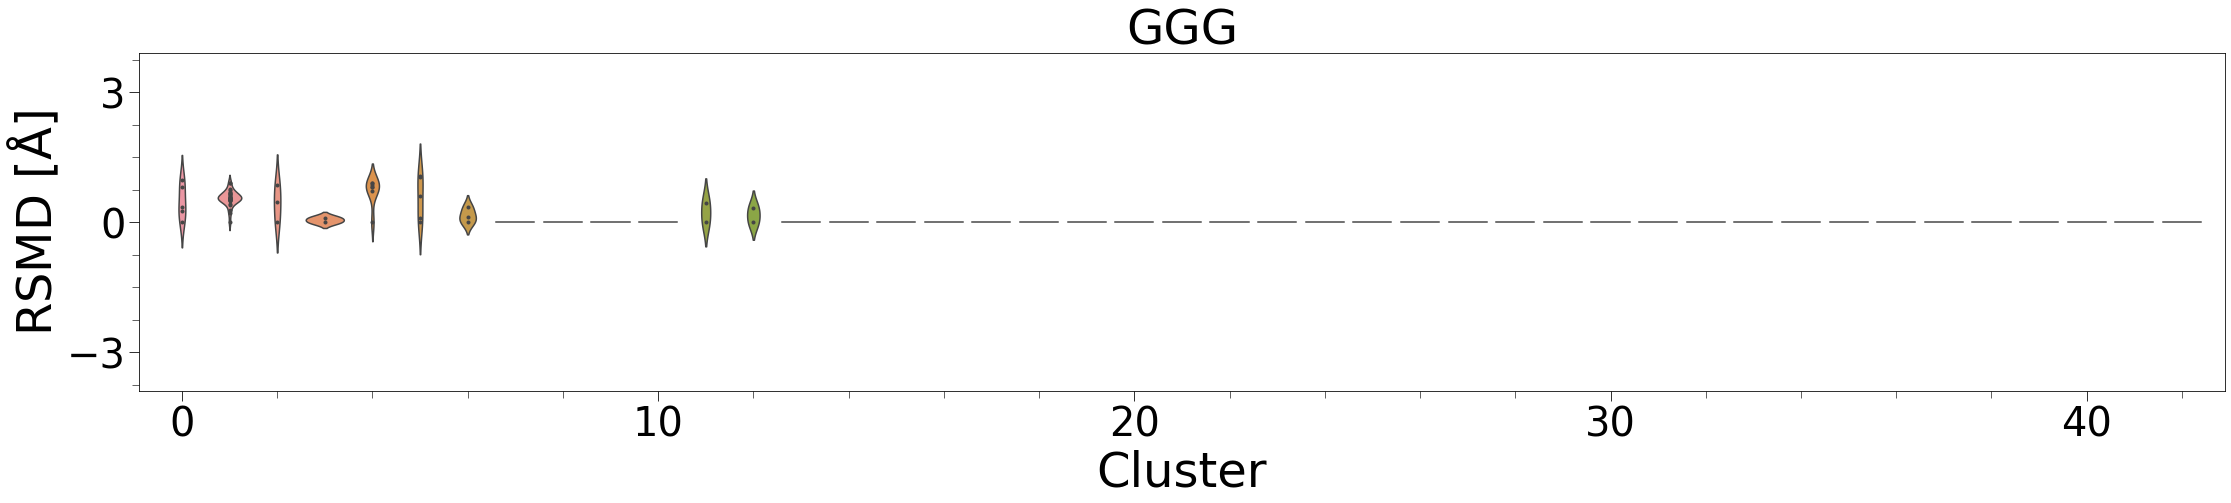

GGC_CGG: 195 files found
0 clusters


""
# of samples
Avg
Std
Max
Min


ValueError: min() arg is an empty sequence

<Figure size 4608x576 with 0 Axes>

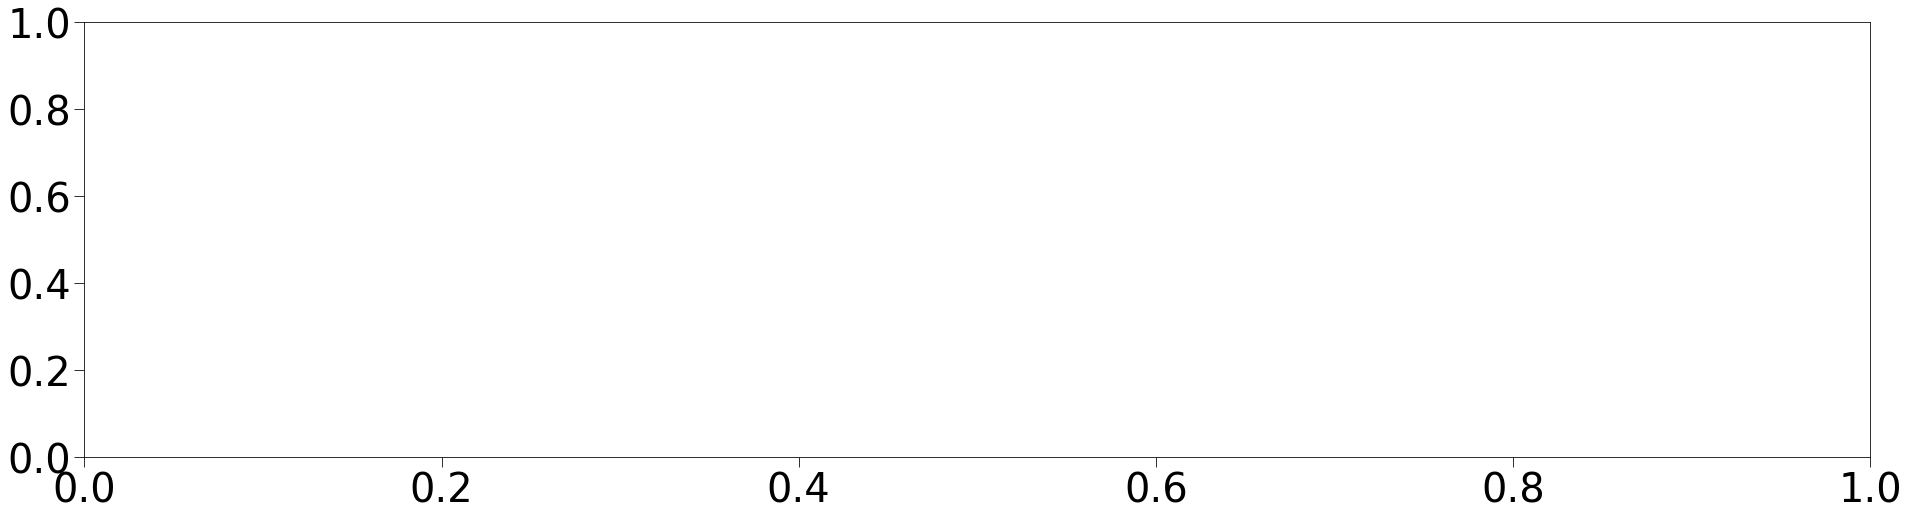

In [17]:
if __name__ == "__main__":
    
    base_path = os.path.dirname(os.path.abspath("__file__")).strip('notebooks')
    output_path = os.path.join(base_path, "pdb", "motif", "cluster")
    dump_path = os.path.join(output_path, "dump")
    release_versions = [ "HairpinLoopMotifAtlasRelease3.57", "InternalLoopMotifAtlasRelease3.57", "nrlist_3.233_2.5A/JunctionLoop" ]
    
    os.makedirs(os.path.join(dump_path), exist_ok = True)      # dump directory to store removed structures
    
    #params = { "method": "ward", "threshold": 20 }      # minimizes the variance of the clusters being merged
    params = { "method": "average", "threshold": 1 }   # uses the average of the distances of each observation of the two sets --> BEST
    #params = { "method": "complete", "threshold": 2 }  # linkage uses the maximum distances between all observations of the two sets
    #params = { "method": "single", "threshold": 10 }    # uses the minimum of the distances between all observations of the two sets
        
    #categories = { "doublebase": 2, "triplebase": 3 }
    categories = { "triplebase": 3 }

    
    n_total = 0
    for category, n in categories.items():
        arr = get_basesets(categories)
        #for seq in arr:
        for a in arr:
            
            """
            """
            seq_forward = ''.join(a)
            seq_backward = ''.join(reversed(a))
            
            if seq_forward == seq_backward:
                dest_path = os.path.join(output_path, category, seq_forward)
                seq = seq_forward
            else:
                dest_path = os.path.join(output_path, category, seq_forward + "_" + seq_backward)
                seq = seq_forward + "_" + seq_backward
            os.makedirs(dest_path, exist_ok = True)
            
            _ = [ glob.glob(output_path.strip('cluster') + "/{}/{}/*_{}_*.pdb".format(release_version, category, seq_forward)) for release_version in release_versions ]
            _ += [ glob.glob(output_path.strip('cluster') + "/{}/{}/*_{}_*.pdb".format(release_version, category, seq_backward)) for release_version in release_versions ]            
            files = list(set([ item for elem in _ for item in elem ]))  # convert nested list into flat list
            print("{}: {} files found".format(seq, len(files)))            
            
            #dest_path = os.path.join(output_path, category, seq)
            #os.makedirs(dest_path, exist_ok = True)
            
            #_ = [ glob.glob(output_path.strip('cluster') + "/{}/{}/*_{}_*.pdb".format(release_version, category, seq)) for release_version in release_versions ]
            #files = list(set([ item for elem in _ for item in elem ]))  # convert nested list into flat list
            #print("{}: {} files found".format(seq, len(files)))
            """
            """

            
            # curate input files
            curated_files = load_file(files, dump_path)

            # calculate features
            feat_torsion = torsion_featurizer(curated_files)
            feat_dist = dist_featurizer(curated_files, atom_slice_interval=1)
            feat_concat = np.concatenate((feat_torsion, feat_dist), axis=1)

            #feat = feat_torsion
            feat = feat_dist
            #feat = feat_concat

            # feature scaling
            #scale = StandardScaler().fit_transform(feat)
            #pca = PCA(svd_solver="full")
            #pca.fit(scale)
            #pca_coord = pca.transform(scale)
            #print("# of components: {} -> {} / explained variance: {:.2f}".format(len(feat[1]), pca.n_components_, pca.explained_variance_ratio_.sum()))

            # clustering
            X = feat
            cluster_labels, centroid_indexes = agglomerative_cluster(X, params)
            #cluster_labels, centroid_indexes = dbscan_cluster(X, params)

            # export cluster centroids
            #n = export_pdb(curated_files, cluster_labels, centroid_indexes, dest_path)
            #n_total += n

            # plot rmsd distribution
            #cluster_path = os.path.join(output_path, category, seq)
            #plot(cluster_path, seq)
            plot(dest_path, seq)

                
                
    print("=======================")
    print("total structures: {}".format(n_total))